In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
from src import *

In [2]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/figures/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x

In [3]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [4]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [8]:
def read_CM4X(fname): 
    ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
    
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    ds = approximate_z(ds)
    ds = ds.where(ds.thkcello > 1e-9)
    return ds

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")
ds = read_CM4X(datadir("CM4Xp125_historical_transient_tracers.zarr"))
ds_ctrl = read_CM4X(datadir("CM4Xp125_piControl_transient_tracers.zarr"))
ds_ctrl = ds_ctrl.isel(year = slice(None, 165))

/tmp/ipykernel_105408/376904265.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(["lat", "lon"])
/tmp/ipykernel_105408/376904265.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(["lat", "lon"])


In [9]:
def weighted_average(ds):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
    return weighted_ds

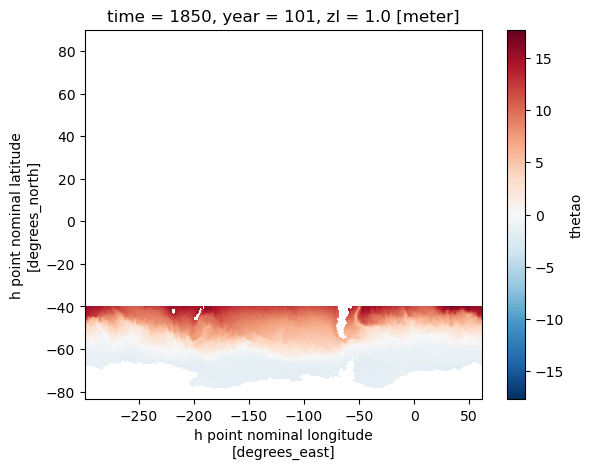

In [10]:
ds_ctrl.where(ds_ctrl.lat < -40).thetao.isel(year = 0, zl = 0).plot()

In [9]:
ds_ctrl = get_sigma2(ds_ctzrl)
ds = get_sigma2(ds)

In [16]:
ctrl_global = weighted_average(ds_ctrl.where(ds_ctrl.lat < -40)).compute()
hist_global = weighted_average(ds.where(ds.lat < -40)).compute()

In [17]:
ctrl_global.to_netcdf(datadir("CM4Xp125_piControl_SO_40S.nc"))

In [18]:
hist_global.to_netcdf(datadir("CM4Xp125_historical_SO_40S.nc"))

In [34]:
cfc11_ctrl = ctrl_global.cfc11.compute()
z_ctrl = ctrl_global.z.compute()

cfc11_hist = hist_global.cfc11.compute()
z_hist = hist_global.z.compute()

Text(0.5, 1.0, 'HIST')

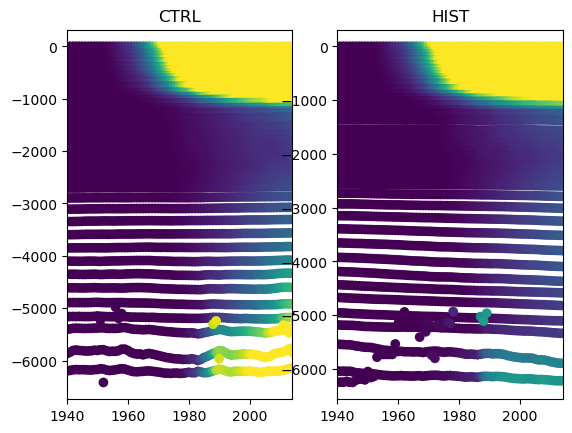

In [35]:
YEARS, _ = np.meshgrid(ds.year, z_ctrl[0, :])

fig, ax = plt.subplots(1, 2, sharex = True)
ax[0].scatter(YEARS, z_ctrl.T, c = cfc11_ctrl.T, vmax = 1e-9, vmin = 1e-11)
ax[0].set_xlim(1940, 2014)
ax[1].scatter(YEARS, z_hist.T, c = cfc11_hist.T, vmax = 1e-9, vmin = 1e-11)
ax[1].set_xlim(1940, 2014)
ax[0].set_title("CTRL")
ax[1].set_title("HIST")


In [50]:
interp_ctrl_timeseries = interpolate_section(ctrl_timeseries, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")
interp_hist_timeseries = interpolate_section(hist_timeseries, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")

In [54]:
interp_ctrl_timeseries.sigma2.min()

<xarray.DataArray 'sigma2' ()>
array(35.96380356)

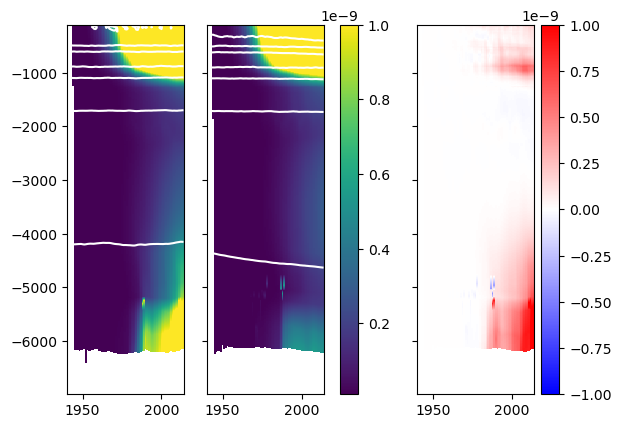

In [62]:

fig, ax = plt.subplots(1, 3, sharey = True)

tmp1 = interp_ctrl_timeseries.cfc11
tmp1 = tmp1.where(tmp1 > 0)
ax[0].pcolormesh(ctrl_timeseries.time, tmp1.z, tmp1, vmax = 1e-9, vmin = 1e-11)
ax[0].contour(ctrl_timeseries.time, tmp1.z, interp_ctrl_timeseries.sigma2, colors = "white")
ax[0].set_xlim(1940, 2014)

tmp2 = interp_hist_timeseries.cfc11
tmp2 = tmp2.where(tmp2 > 0)
cm = ax[1].pcolormesh(hist_timeseries.year, tmp2.z, tmp2, vmax = 1e-9, vmin = 1e-11)
ax[1].contour(hist_timeseries.year, tmp1.z, interp_hist_timeseries.sigma2, colors = "white")

ax[1].set_xlim(1940, 2014)

tmp3 = tmp1.values - tmp2.values
cm1 = ax[2].pcolormesh(hist_timeseries.year, tmp2.z, tmp3, vmin = -1e-9, vmax = 1e-9, cmap = "bwr")
ax[2].set_xlim(1940, 2014)

fig.colorbar(cm, ax = ax[0:2])
fig.colorbar(cm1, ax = ax[2])